In [128]:
import numpy as np
import matplotlib.pyplot as plt
import random
import csv

# inputs: 
# v, an array of payoffs for each action j at a given turn i
# epsilon, the learning rate
# h, the range of the payoffs
# outputs:
# weights, weights for each action at a given turn
# pi, optimal probabilities for picking each action at a given turn
def exponential_weights(v, epsilon, h):
    V = np.cumsum(v, axis=1)
    weights = np.power((1 + epsilon), V[:, :-1]/h)
    # because we're referencing the previous column, the first
    # column of ones gets removed so we need to add it back
    weights = np.insert(weights, 0, np.ones(v.shape[0]), axis=1)
    pi = np.divide(weights, np.sum(weights, axis=0))
    return weights, pi

# a
def adversarial_fair_payoffs(actions, rounds):
    V = np.zeros(shape=[actions, ])
    payoffs = np.zeros(shape=[actions, rounds])
    for i in range(rounds):
        x = np.random.uniform(0,1)
        j_star = np.argmin(V)
        payoffs[j_star][i] = x
        V[j_star] += x

    return payoffs

#b
def bernoulli_payoffs(actions, rounds):
    probabilities = list(map(lambda a: np.random.uniform(0, 0.5), np.zeros(shape=[actions, ])))
    payoffs = np.zeros(shape=[actions, rounds])
    for i in range(rounds):
        for j in range(actions):
            if np.random.uniform(0, 1) < probabilities[j]:
                payoffs[j][i] = 1
               
    return payoffs

#c
def bulls_data():
    data = np.genfromtxt('BullsData.csv', delimiter=',')
    # remove the dates/player names
    data = np.delete(data, 0, axis=0) 
    data = np.delete(data, -1, axis=0) 
    data = np.delete(data, 0, axis=1)
    
    return data

#d
def poisson_payoffs(actions, rounds):
    return np.array([[1, 1], [1, 1]])

In [129]:
def random_pick(probability_array):
    random_number = random.random()
    cumulative_probability = 0.0
    for index, probability in enumerate(probability_array):
        cumulative_probability += probability
        if random_number < cumulative_probability:
            return index
    return len(probability_array) - 1

def regret(payoffs, EW):
    optimal_sum = 0
    EW_sum = 0
    n = payoffs.shape[1]

    for i in range(n):
        j = np.argmax(payoffs[:, i])
        optimal_sum += payoffs[j][i]
        j_i = random_pick(EW[:, i]) # randomly pick an action according to the EW probabilities
        EW_sum += payoffs[j_i, i]

    # print(1 / n * (optimal_sum-EW_sum))
    return 1 / n * (optimal_sum-EW_sum)

def write_dictionary_to_csv(input_dictionary, file_name):
    with open(file_name, 'w+', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        for key, arr in input_dictionary.items():
            writer.writerow(np.concatenate([np.array([key]), np.squeeze(arr)]))

In [130]:
def get_graphs_for_parameters():
    N = 100
    STEP = 250
    END = 10000
    a_rounds_regret = np.zeros(int(END/STEP))
    b_rounds_regret = np.zeros(int(END/STEP))
    actions = 20
    for rounds in range(STEP, END, STEP):
        # average results from N samples
        a_sum = 0
        b_sum = 0
        epsilon = np.power(np.log(actions)/rounds, 1/2)
        for i in range(N):
            a_payoffs = adversarial_fair_payoffs(actions, rounds)
            b_payoffs = bernoulli_payoffs(actions, rounds)
            _, a_EW = exponential_weights(a_payoffs, epsilon, 1)
            _, b_EW = exponential_weights(b_payoffs, epsilon, 1)
            a_sum += regret(a_payoffs, a_EW)
            b_sum += regret(b_payoffs, b_EW)
        a_rounds_regret[int(rounds/STEP)] = a_sum/N
        b_rounds_regret[int(rounds/STEP)] = b_sum/N

    plt.plot(list(range(0, END, STEP)), a_rounds_regret, color="red", label="Adversarial Fair Payoff")
    plt.plot(list(range(0, END, STEP)), b_rounds_regret, color="blue", label="Bernoulli Payoff")
    plt.xlabel('Rounds')
    plt.ylabel('Regret')
    plt.title('Regret vs Rounds')
    plt.legend()
    plt.show()

    STEP = 4
    END = 100
    a_actions_regret = np.zeros(int(END/STEP))
    b_actions_regret = np.zeros(int(END/STEP))
    rounds = 20
    for actions in range(STEP, END, STEP):
        # average results from N samples
        a_sum = 0
        b_sum = 0
        epsilon = np.power(np.log(actions)/rounds, 1/2)
        for _ in range(N):
            a_payoffs = adversarial_fair_payoffs(actions, rounds)
            b_payoffs = bernoulli_payoffs(actions, rounds)
            _, a_EW = exponential_weights(a_payoffs, epsilon, 1)
            _, b_EW = exponential_weights(b_payoffs, epsilon, 1)
            a_sum += regret(a_payoffs, a_EW)
            b_sum += regret(b_payoffs, b_EW)
        a_actions_regret[int(actions/STEP)] = a_sum/N
        b_actions_regret[int(actions/STEP)] = b_sum/N
        
    plt.plot(list(range(0, END, STEP)), a_actions_regret, color="red", label="Adversarial Fair Payoff")
    plt.plot(list(range(0, END, STEP)), b_actions_regret, color="blue", label="Bernoulli Payoff")
    plt.xlabel('Actions')
    plt.ylabel('Regret')
    plt.title('Regret vs Actions')
    plt.legend()
    plt.show()

def analyze_payoffs(step, end, divisor=1):
    N = 100
    regrets = {
        "Adversarial Fair": np.ones(int(end/step)), 
        "Bernoulli": np.ones(int(end/step)), 
        "Chicago Bulls": np.ones(int(end/step)), 
        "Poisson": np.ones(int(end/step))
    }
    actions = 20
    rounds = 1000
    for epsilon in range(0, end, step):
        # average results from N samples
        epsilon = float(epsilon)/divisor
        a_sum = 0
        b_sum = 0
        c_sum = 0
        d_sum = 0
        for i in range(N):
            a_payoffs = adversarial_fair_payoffs(actions, rounds)
            b_payoffs = bernoulli_payoffs(actions, rounds)
            c_payoffs = bulls_data()
            d_payoffs = poisson_payoffs(actions, rounds)
            _, a_EW = exponential_weights(a_payoffs, epsilon, 1)
            _, b_EW = exponential_weights(b_payoffs, epsilon, 1)
            _, c_EW = exponential_weights(c_payoffs, epsilon, 44) #44 is the max points scored in the data
            _, d_EW = exponential_weights(d_payoffs, epsilon, 1)
            a_sum += regret(a_payoffs, a_EW)
            b_sum += regret(b_payoffs, b_EW)
            c_sum += regret(c_payoffs, c_EW)
            d_sum += regret(d_payoffs, d_EW)
        regrets["Adversarial Fair"][int(np.round(epsilon/step*divisor))] = a_sum/N
        regrets["Bernoulli"][int(np.round(epsilon/step*divisor))] = b_sum/N
        regrets["Chicago Bulls"][int(np.round(epsilon/step*divisor))] = c_sum/44/N
        regrets["Poisson"][int(np.round(epsilon/step*divisor))] = d_sum/N

    return regrets

def plot_regrets(regrets, step, end, divisor=1, include_bulls=True):
    # print(np.argmin(regrets["Adversarial Fair"]), np.min(regrets["Adversarial Fair"]))
    # print(np.argmin(regrets["Bernoulli"]), np.min(regrets["Bernoulli"]))
    # print(np.argmin(regrets["Chicago Bulls"]), np.min(regrets["Chicago Bulls"]))
    # print(np.argmin(regrets["Poisson"]), np.min(regrets["Poisson"]))

    for payoff in regrets.keys():
        if (payoff != "Chicago Bulls") | include_bulls:
            plt.plot(np.divide(list(range(0, end, step)), divisor), regrets[payoff], label=payoff)
    plt.xlabel('Epsilon')
    plt.ylabel('Regret')
    plt.title('Regret vs Epsilon')
    plt.legend()
    plt.show()

In [131]:
# testing
def test_example_from_class():
    weights, pi = exponential_weights(np.array([[1, 1, 0, 0], [0, 0, 1, 1]]), 1, 1)
    assert np.array_equal(weights, [[1, 2, 4, 4], [1, 1, 1, 2]])
    assert np.array_equal(pi, [[1/2, 2/3, 4/5, 2/3], [1/2, 1/3, 1/5, 1/3]])

In [ ]:
test_example_from_class()
print("Test passed")

In [132]:
step = 1
end = 100
small_regrets = analyze_payoffs(step, end, divisor=100)
large_regrets = analyze_payoffs(step, end)

Test passed


C:\Users\owenm\AppData\Local\Temp\ipykernel_12128\958634464.py:15: RuntimeWarning: overflow encountered in power
  weights = np.power((1 + epsilon), V[:, :-1]/h)
C:\Users\owenm\AppData\Local\Temp\ipykernel_12128\958634464.py:19: RuntimeWarning: invalid value encountered in divide
  pi = np.divide(weights, np.sum(weights, axis=0))
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


KeyboardInterrupt: 

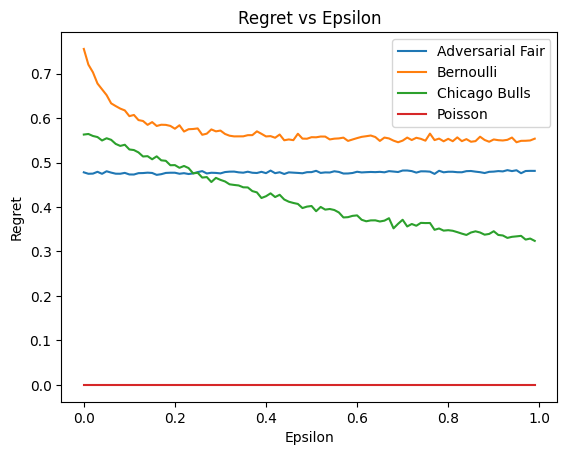

In [ ]:
write_dictionary_to_csv(small_regrets, "regrets_small.csv")
plot_regrets(small_regrets, step, end, divisor=100)
#plot_regrets(small_regrets, step, end, divisor=100, include_bulls=False)

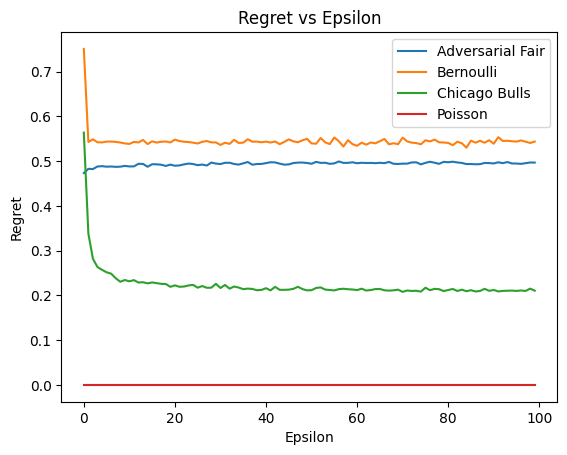

In [ ]:
write_dictionary_to_csv(large_regrets, "large_regrets.csv")
plot_regrets(large_regrets, step, end)
#plot_regrets(large_regrets, step, end, include_bulls=False)

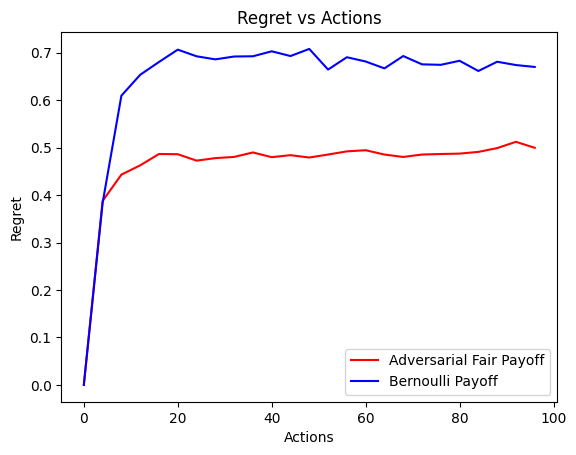

In [127]:
get_graphs_for_parameters()